# Classification Model for Bank Marketing Data

The goal of this study was to fit and compare classifiers to predict whether an individual will subscribe to a term deposit from the direct marketing campaigns (phone calls) of a Portuguese banking institution run between 2008 to 2010.The data sets were sourced from the UCI Machine LearningRepository. The data data set has 45,211 observations and consist of 16 descriptives features and one target feature i.e. Term Deposit.

This report is organized as follows:
- [Section 1 (Introduction)](#1) outlines our methodology. 
- [Section 2 (Data Preparation)](#2) summarizes the data preparation process and our model evaluation strategy. 
- [Section 3 (Evaluate Algorithms)](#3) outlines evaluating the performance of set of algorithms.
- [Section 4 (Hyperparameter Tuning)](#4) describes the hyperparameter tuning process for each classification algorithm.
- [Section 5 (Performance Comparison)](#5) presents model performance comparison results.
- [Section 6 (Limitations)](#6) discusses a limitations of our approach and possible solutions. 
- [Section 7 (Colclusion)](#7) provides a brief summary of our work in this project.

# Introduction <a class="anchor" id="1"></a> 

The Bank Marketing dataset involves predicting the whether the bank clients will subscribe (yes/no) to a term deposit (target variable). It is a binary (2-class) classification problem. Hence, we build the following binary classifiers to predict the target feature:

* K-Nearest Neighbors (KNN),
* Decision trees (DT), 
* Naive Bayes (NB) and
* Logistic Regression (LR)

The project had two phases. Phase I focused on data pre-processing and exploration. We shall present model building and evaluation in this phase. 

Our modelling strategy begins by doing a statistical and exploratory analysis of data, post which we will transform our data by encoding categorical descriptive features as numerical and then scaling of the descriptive features using a `Min-Max` scaler.

We first randomly sample 10K rows from the full dataset and then split this sample into training and test sets with a 70:30 ratio. This way, our training data has 7k rows and test data has 3K rows.

Before fitting a particular model, we select the best features using the Random Forest Importance method inside a pipeline. We consider 10, 20, and the full set of 47 features (after encoding of categorical features). 
Since the target feature `term_deposit` is unbalanced (more no than yes), stratification was used to ensure same proportion (as in original data) in the train test split.


After the data preparation we work on finding a workable model by evaluating a subset of machine learning algorithms.


Next, we use feature selection together with hyperparameter search inside a single pipeline, we conduct a 5-fold `RepeatedStratifiedKFold` cross-validation with 3 repetitions to fine-tune hyperparameters of each classifier using area under curve (AUC) as the performance metric.

To speed up the execution we build each model using parallel processing with "-2" cores. 

Once the best model is identified for each of the three classifier types using a hyperparameter search on the training data, we did a 3-repeated 10-fold cross-validation on the test data and perform a paired t-test to see if the performance difference is statistically significant. In addition, we compare the classifiers with respect to their recall scores and confusion matrices on the test data.



# Data Preparation <a class="anchor" id="2"></a> 

### Load Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

### Read the data

In [3]:
bank_data = pd.read_csv('~/Dropbox/MC242/ML/R/bank/bank-full.csv',sep=';')

In [246]:
#Dimensions of the dataset
print(bank_data.shape)

(45211, 17)


In [4]:
bank_data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


As we observed during the data exploration during Phase I , `pdays` i.e. *number of days that passed by after the client was last contacted from a previous campaign* has majority values (around 37k of the total 45k rows) as -1 representing the customer wasn't contacted. We will drop this feature from our dataset. 

In [5]:
print (bank_data[bank_data.pdays == -1].shape[0])

36954


In [6]:
del bank_data['pdays']

In [7]:
#rename the target feature from y to Term_Deposit
bank_data = bank_data.rename(columns={'y': 'Term_Deposit'})

In [8]:
bank_data.columns

Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'previous',
       'poutcome', 'Term_Deposit'],
      dtype='object')

In [9]:
bank_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 16 columns):
age             45211 non-null int64
job             45211 non-null object
marital         45211 non-null object
education       45211 non-null object
default         45211 non-null object
balance         45211 non-null int64
housing         45211 non-null object
loan            45211 non-null object
contact         45211 non-null object
day             45211 non-null int64
month           45211 non-null object
duration        45211 non-null int64
campaign        45211 non-null int64
previous        45211 non-null int64
poutcome        45211 non-null object
Term_Deposit    45211 non-null object
dtypes: int64(6), object(10)
memory usage: 5.5+ MB


Full data has 45,211 observations. It has 15 descriptive features and  "Term_Depost" as target feature. 

## Missing Data

We can use a simple heatmap to see whether we are missing data.

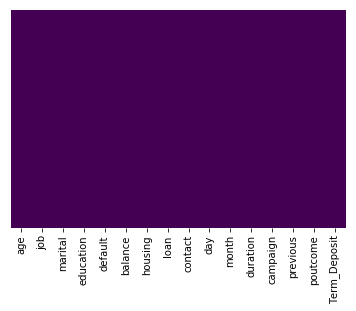

In [253]:
sns.heatmap(bank_data.isnull(),yticklabels=False,cbar=False,cmap='viridis')

There are no missing values in our dataset.

## Summary Statistics

The summary statistics for the full data are shown below.

In [254]:
bank_data.describe()

,age,balance,day,duration,campaign,previous
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,1362.272058,15.806419,258.163080,2.763841,0.580323
std,10.618762,3044.765829,8.322476,257.527812,3.098021,2.303441
min,18.000000,-8019.000000,1.000000,0.000000,1.000000,0.000000
25%,33.000000,72.000000,8.000000,103.000000,1.000000,0.000000
50%,39.000000,448.000000,16.000000,180.000000,2.000000,0.000000
75%,48.000000,1428.000000,21.000000,319.000000,3.000000,0.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000,275.000000


Summarize the levels of the class attribute.

In [255]:
print(bank_data.Term_Deposit.value_counts())

no     39922
yes     5289
Name: Term_Deposit, dtype: int64


### Exploratory Data Analysis

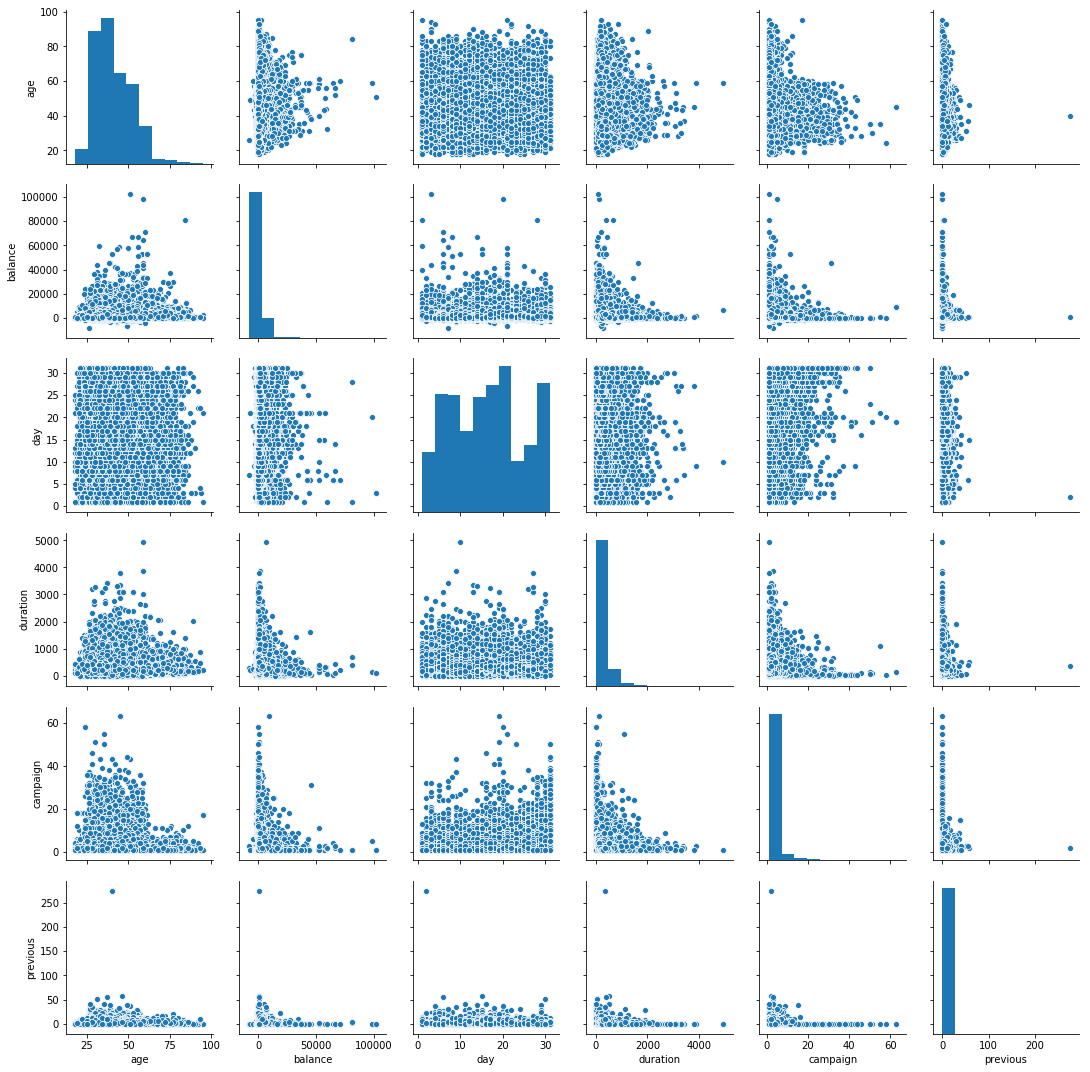

In [256]:
sns.pairplot(bank_data)

We can observe that data here is not-symmetric. Lets look at the correlation matrix to look into the details.

In [257]:
bank_data.corr()

,age,balance,day,duration,campaign,previous
age,1.000000,0.097783,-0.009120,-0.004648,0.004760,0.001288
balance,0.097783,1.000000,0.004503,0.021560,-0.014578,0.016674
day,-0.009120,0.004503,1.000000,-0.030206,0.162490,-0.051710
duration,-0.004648,0.021560,-0.030206,1.000000,-0.084570,0.001203
campaign,0.004760,-0.014578,0.162490,-0.084570,1.000000,-0.032855
previous,0.001288,0.016674,-0.051710,0.001203,-0.032855,1.000000


Heatplot to visualise correlation

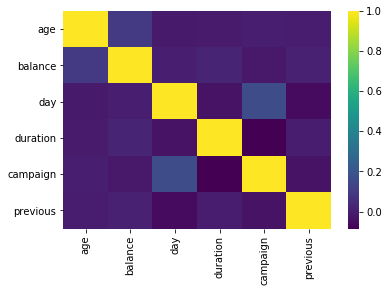

In [258]:
sns.heatmap(bank_data.corr(),annot=False,fmt=".2f",cmap="viridis")
#sns.heatmap(bank_data[num])

### Observations:
- As per the pairplot, correlation matrix, and heatmap, observations as follow:
- Data is non-linear, asymmetric
- Hence selection of features will not depend upon correlation factor.
- Also not a single feature is correlated strongly with class, hence requires combination of features.We will explore feature selection using RFI(Random Forest Importance) in the Feature Selection section. 

## Encoding Categorical Features

Prior to modeling, it is essential to encode all categorical features (both the target feature and the descriptive features) into a set of numerical features.

### Encoding the Target Feature
We will remove the "Term_Deposit" feature from the full dataset and call it "target". The rest of the features are the descriptive features which we call "Data".

In [19]:
Data = bank_data.drop('Term_Deposit',axis=1)
target = bank_data['Term_Deposit']
target.value_counts()

no     39922
yes     5289
Name: Term_Deposit, dtype: int64

Encode the target feature yes and no as 1 and 0's. 

In [20]:
target = target.replace({'no': 0, 'yes': 1})
target.value_counts()

0    39922
1     5289
Name: Term_Deposit, dtype: int64

**We can clearly see that there are only few cases where customer has signed for Term Deposit.** 

### Encoding Categorical Descriptive Features

We'll need to convert categorical features to dummy variables using one-hit encoding Otherwise our machine learning algorithm won't be able to directly take in those features as inputs.

In [21]:
Data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 15 columns):
age          45211 non-null int64
job          45211 non-null object
marital      45211 non-null object
education    45211 non-null object
default      45211 non-null object
balance      45211 non-null int64
housing      45211 non-null object
loan         45211 non-null object
contact      45211 non-null object
day          45211 non-null int64
month        45211 non-null object
duration     45211 non-null int64
campaign     45211 non-null int64
previous     45211 non-null int64
poutcome     45211 non-null object
dtypes: int64(6), object(9)
memory usage: 5.2+ MB


For each two-level categorical variable, we set the `drop_first` option to `True` to encode the variable into a single column of 0 or 1. Next, we apply the `get_dummies()` function for the regular one-hot encoding for categorical features with more than 2 levels.

In [22]:
for cols in Data.columns[Data.dtypes==object]:
    n = len(Data[cols].unique())
    if (n == 2):
        Data[cols] = pd.get_dummies(Data[cols], drop_first=True)
   
# use one-hot-encoding for categorical features with >2 levels
Data = pd.get_dummies(Data)

After encoding, the feature set has the following columns.

In [23]:
Data.columns

Index(['age', 'default', 'balance', 'housing', 'loan', 'day', 'duration',
       'campaign', 'previous', 'job_admin.', 'job_blue-collar',
       'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired',
       'job_self-employed', 'job_services', 'job_student', 'job_technician',
       'job_unemployed', 'job_unknown', 'marital_divorced', 'marital_married',
       'marital_single', 'education_primary', 'education_secondary',
       'education_tertiary', 'education_unknown', 'contact_cellular',
       'contact_telephone', 'contact_unknown', 'month_apr', 'month_aug',
       'month_dec', 'month_feb', 'month_jan', 'month_jul', 'month_jun',
       'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep',
       'poutcome_failure', 'poutcome_other', 'poutcome_success',
       'poutcome_unknown'],
      dtype='object')

In [264]:
Data.head(5)

,age,default,balance,housing,loan,day,duration,campaign,previous,job_admin.,...,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
0,58,0,2143,1,0,5,261,1,0,0,...,0,0,1,0,0,0,0,0,0,1
1,44,0,29,1,0,5,151,1,0,0,...,0,0,1,0,0,0,0,0,0,1
2,33,0,2,1,1,5,76,1,0,0,...,0,0,1,0,0,0,0,0,0,1
3,47,0,1506,1,0,5,92,1,0,0,...,0,0,1,0,0,0,0,0,0,1
4,33,0,1,0,0,5,198,1,0,0,...,0,0,1,0,0,0,0,0,0,1


## Features Scaling

We will normalize the descriptive features so that they have 0 mean and 1 standard deviation.

In [24]:
Data_copy = Data.copy()
from sklearn.preprocessing import MinMaxScaler
Sd_scaler = MinMaxScaler()
Data = Sd_scaler.fit_transform(Data)

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [25]:
pd.DataFrame(Data,columns=Data_copy.columns).head(5)

,age,default,balance,housing,loan,day,duration,campaign,previous,job_admin.,...,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
0,0.519481,0.0,0.092259,1.0,0.0,0.133333,0.053070,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.337662,0.0,0.073067,1.0,0.0,0.133333,0.030704,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.194805,0.0,0.072822,1.0,1.0,0.133333,0.015453,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.376623,0.0,0.086476,1.0,0.0,0.133333,0.018707,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.194805,0.0,0.072812,0.0,0.0,0.133333,0.040260,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


## Feature Selection & Ranking

To gain a better understanding of our dataset, we visualise the best 10 features using Random Forest Importance (RFI)- an ensemble-based filter method. This is a filter feature selection method that uses the total decrease in node impurities from splitting on a particular feature as averaged over all decision trees in the ensemble.

We will perform RFI feature selection using 100 trees.

In [26]:
from sklearn.ensemble import RandomForestClassifier
model_rfi = RandomForestClassifier(n_estimators=100)
model_rfi.fit(Data, target)
fs_indices_rfi = np.argsort(model_rfi.feature_importances_)[::-1][0:10]

The best features selected by RFI.

In [27]:
best_features_rfi = Data_copy.columns[fs_indices_rfi].values
best_features_rfi

array(['duration', 'balance', 'age', 'day', 'poutcome_success',
       'campaign', 'previous', 'housing', 'month_mar', 'month_apr'],
      dtype=object)

In [31]:
feature_importances_rfi = model_rfi.feature_importances_[fs_indices_rfi]
feature_importances_rfi

array([0.26901733, 0.09887779, 0.09725924, 0.08729177, 0.05022403,
       0.04022991, 0.02590344, 0.02221216, 0.01316732, 0.01225898])

In [32]:
temp = pd.DataFrame({'Feature': best_features_rfi, 
                       'Score': feature_importances_rfi})
temp

,Feature,Score
0,duration,0.269017
1,balance,0.098878
2,age,0.097259
3,day,0.087292
4,poutcome_success,0.050224
5,campaign,0.040230
6,previous,0.025903
7,housing,0.022212
8,month_mar,0.013167
9,month_apr,0.012259


<BarContainer object of 10 artists>

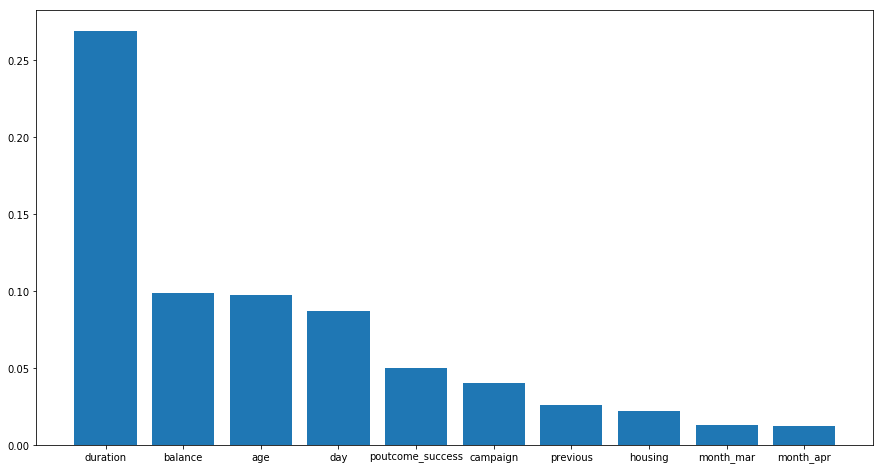

In [33]:
plt.figure(figsize=(15, 8))
plt.bar(temp['Feature'],temp['Score'])

We can note that call duration is the most important feature followed by account balance and age of the client.

## Data Sampling 

The original dataset has more than 45K rows, we will take a random sample of 10k rows for model fitting as its computationaly exhausting to fit the model on the complete data set. 

In [34]:
n_samples = 10000
seedNum = 101

Data_sample = pd.DataFrame(Data).sample(n=n_samples, random_state=seedNum).values
target_sample = pd.DataFrame(target).sample(n=n_samples, random_state=seedNum).values

print(Data_sample.shape)
print(target_sample.shape)

(10000, 47)
(10000, 1)


## Train Test Split

We split the descriptive features and the target feature into a training set and a test set by a ratio of 70:30. We will train out model on the training set and then use the test set to evaluate the model.

We saw earlier that the target feature is not proportionate ( around 5k yes against 40k No approx), in order to ensure the proportion is not deviating from the original ratio  when splitting the data, we set the `stratify` option in `train_test_split` function.

Also, in order to be able to replicate our analysis later on, we set the `random_state` option to `seedNum`.

In [35]:
from sklearn.model_selection import train_test_split

Data_train, Data_test, target_train, target_test = train_test_split(Data_sample, target_sample, 
                                                                    test_size = 0.30,stratify = target_sample)

print(Data_train.shape)
print(Data_test.shape)

(7000, 47)
(3000, 47)


# Evaluate Algorithms <a class="anchor" id="3"></a> 


After the data-prep, we next work on finding a workable model by evaluating a subset of machine learning algorithms that are good at exploiting the structure of the training data. The evaluation tasks includes:
- Defining test options such as cross validation and the evaluation metric to use.
- Spot checking a suite of linear and nonlinear machine learning algorithms.
- Comparing the estimated accuracy of algorithms.

For this project, we will evaluate one linear, three non-linear algorithms:

**Linear Algorithms:** Logistic Regression 

**Non-Linear Algorithms:** Decision Trees, Naive Bayes, k-Nearest Neighbors

The random number seed is reset before each run to ensure that the evaluation of each algorithm is performed using the same data splits. It ensures the results are directly comparable.

 ### Set test options and evaluation metric

We would like to assess performance of each algorithms(by accuracy score) using all the features on the dataset. For assessment, we shall use stratified 5-fold cross-validation with 3 repetitions. We set the random state to `seedNum` so that our results can be replicated and verified later on exactly as they are.

In [36]:
# Run algorithms using 5-fold cross validation
num_folds = 5
scoring = 'accuracy'

In [37]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier


# Set up Algorithms Spot-Checking Array
models = []
models.append(('LR', LogisticRegression()))
models.append(('DT', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('KNN', KNeighborsClassifier()))
results = []
names = []


In [38]:
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold
print("Classifier :" + " cv_result :" + " cv_result std ")
for name,model in models:
    cv_method = RepeatedStratifiedKFold(n_splits=num_folds,n_repeats=3, random_state=seedNum)
    cv_result = cross_val_score(model,Data_train,target_train,cv=cv_method,scoring=scoring)
    results.append(name)
    msg = "%s:  %f  (%f)" % (name, cv_result.mean(), cv_result.std())
    print(msg)


Classifier : cv_result : cv_result std 
LR:  0.897525  (0.005336)
DT:  0.865382  (0.007664)
NB:  0.854333  (0.010174)
KNN:  0.884096  (0.004806)


### Observation:

- From the above CV results we can see that Logistic Regression is our best performing models followed by KNN. 
- Logistic Regression gave us the best accuracy (around 90%) with very minimum variance. 

## Model Evaluation Strategy

Next, we will train and tune each of the above  models on the training data and we will test them on of the test data. 

For each model, we will use 5-fold stratified cross-validation evaluation method (with 3 repeatitions) for hyperparameter tuning.

# Hyperparameter Tuning <a class="anchor" id="4"></a> 

- Using `Pipeline`, we stack feature selection and random search for KNN hyperparameter tuning via cross-validation. We will use the same `Pipeline` methodology for NB and DT.
- `RandomizedSearchCV`is used instead of Grid Search for the obvious reason of saving computation cost. 



### K-Nearest Neighbors (KNN)

The KNN hyperparameters are as follows:

* number of neighbors (`n_neighbors`) and
* the distance metric `p`.

For feature selection, we used the Random Forest Importance (RFI) method with 100 estimators. We define the custom `RFIFeatureSelector()` class below to pass in RFI as a "step" to the pipeline.

In [39]:
from sklearn.base import BaseEstimator, TransformerMixin

# custom function for RFI feature selection inside a pipeline
# here we use n_estimators=100
class RFIFeatureSelector(BaseEstimator, TransformerMixin):
    
    # class constructor 
    def __init__(self, n_features_=10):
        self.n_features_ = n_features_
        self.fs_indices_ = None

    # override the fit function
    def fit(self, X, y):
        from sklearn.ensemble import RandomForestClassifier
        from numpy import argsort
        model_rfi = RandomForestClassifier(n_estimators=100)
        model_rfi.fit(X, y)
        self.fs_indices_ = argsort(model_rfi.feature_importances_)[::-1][0:self.n_features_] 
        return self 
    
    # override the transform function
    def transform(self, X, y=None):
        return X[:, self.fs_indices_]


In [40]:
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier

pipe_KNN = Pipeline(steps=[('rfi_fs', RFIFeatureSelector()), 
                           ('knn', KNeighborsClassifier())])

params_pipe_KNN = {'rfi_fs__n_features_': [10, 20, Data.shape[1]],
                   'knn__n_neighbors': [1, 10, 20, 40, 60, 100],
                   'knn__p': [1, 2]}
n_iter_search =10
rs_pipe_KNN = RandomizedSearchCV(estimator=pipe_KNN, 
                           param_distributions=params_pipe_KNN, 
                           cv=cv_method,
                           refit=True,
                           n_jobs=-2,
                        n_iter=n_iter_search,
                           scoring='roc_auc',
                           verbose=1) 

In [41]:
#fit with training data
rs_pipe_KNN.fit(Data_train, target_train);

Fitting 15 folds for each of 10 candidates, totalling 150 fits


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=-2)]: Done  44 tasks      | elapsed:   23.0s
[Parallel(n_jobs=-2)]: Done 150 out of 150 | elapsed:  2.0min finished


In [42]:
rs_pipe_KNN.best_params_

{'rfi_fs__n_features_': 10, 'knn__p': 2, 'knn__n_neighbors': 40}

In [43]:
rs_pipe_KNN.best_score_

0.8595478957280618

We observe that the optimal KNN model has a mean AUC score of 0.86. The best performing KNN selected 10 features with 100 nearest neighbors and $p=1$.

To extract more cross-validation results, we can call `rs.csv_results` - a dictionary consisting of run details for each fold.   

In [281]:
rs_pipe_KNN.cv_results_['mean_test_score']

array([0.74992557, 0.85618774, 0.86478754, 0.83421407, 0.74441288,
       0.62223057, 0.74212895, 0.76952042, 0.84809677, 0.76416548])

In [283]:
import pandas as pd

#create a new df combining params with  test score 
results_rs_pipe_KNN = pd.DataFrame(rs_pipe_KNN.cv_results_['params'])
results_rs_pipe_KNN['test_score'] = rs_pipe_KNN.cv_results_['mean_test_score']
#create a new column called "metric" to stores the name of the metric for each  knn_p  value.
results_rs_pipe_KNN['metric'] = results_rs_pipe_KNN['knn__p'].replace([1,2], ["Manhattan", "Euclidean",])

In [299]:
results_rs_pipe_KNN.head(5)

,knn__n_neighbors,knn__p,rfi_fs__n_features_,test_score,metric
0,10,2,20,0.749926,Euclidean
1,100,2,10,0.856188,Euclidean
2,100,1,10,0.864788,Manhattan
3,10,1,10,0.834214,Manhattan
4,60,2,20,0.744413,Euclidean


We observe that the difference between the hyperparameter combinations is not really much when conditioned on the number of features selected. 

### (Gaussian) Naive Bayes (NB)

- Next we will fit a Gaussian Naive Bayes model and optimize its only parameter, `var_smoothing`, using a grid search.

- The var_smoothing parameter's default value is  $10^{-9}$ . We will conduct the grid search in the `logspace`, that is, we will search over the powers of 10. We will start with $10$ and end with  $10^{-9}$ and we will try $100$ different values ,but we perform a random search over only 10 different values (for shorter run times).


- Since NB requires each descriptive feature to follow a normal distribution, we first perform a power transformation on the input data before model fitting to make it more or less normally distributed. 

In [44]:
from sklearn import preprocessing
from sklearn.preprocessing import PowerTransformer
Data_train_transformed = PowerTransformer().fit_transform(Data_train)

In [53]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import RandomizedSearchCV

pipe_NB = Pipeline([('rfi_fs', RFIFeatureSelector()), 
                     ('nb', GaussianNB())])

params_pipe_NB = {'rfi_fs__n_features_': [10, 20, Data.shape[1]],
                  'nb__var_smoothing': np.logspace(1,-9, num=100)}

n_iter_search = 10
rs_pipe_NB = RandomizedSearchCV(estimator=pipe_NB, 
                          param_distributions=params_pipe_NB, 
                          cv=cv_method,
                          refit=True,
                          n_jobs=-2,
                          scoring='roc_auc',
                          n_iter=n_iter_search,
                          verbose=1) 

rs_pipe_NB.fit(Data_train_transformed, target_train);

Fitting 15 folds for each of 10 candidates, totalling 150 fits


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=-2)]: Done  44 tasks      | elapsed:   14.9s
[Parallel(n_jobs=-2)]: Done 150 out of 150 | elapsed:   39.2s finished


In [51]:
rs_pipe_NB.best_params_

{'rfi_fs__n_features_': 10, 'nb__var_smoothing': 1.2618568830660185e-09}

In [52]:
rs_pipe_NB.best_score_

0.8648297914598634

The optimal NB yields an AUC score of 0.50 (with 10 features) - much lower than that of KNN. At this point, we cannot conclude KNN outperforms NB. For this conclusion, we will have to perform a paired t-test on the test data as discussed further below.

To extract more cross-validation results, we can call rs.csv_results - a dictionary consisting of run details for each fold.

In [290]:
results_rs_pipe_NB = pd.DataFrame(rs_pipe_NB.cv_results_['params'])
results_rs_pipe_NB['test_score'] = rs_pipe_NB.cv_results_['mean_test_score']

In [291]:
results_rs_pipe_NB.head(5)

,nb__var_smoothing,rfi_fs__n_features_,test_score
0,6.892612e-06,47,0.478891
1,1.261857e-09,47,0.478890
2,3.053856e-01,10,0.500388
3,4.037017e-09,47,0.478890
4,2.848036e-04,20,0.484128


We can note that for the same number of features, there is not much difference in the AUC Score for various values of var_smoothing parameter. 

### Decision Trees (DT)

We build a DT using gini index to maximize information gain. We aim to determine the optimal combinations of maximum depth (`max_depth`) and minimum sample split (`min_samples_split`).

In [292]:
from sklearn.tree import DecisionTreeClassifier

pipe_DT = Pipeline([('rfi_fs', RFIFeatureSelector()),
                    ('dt', DecisionTreeClassifier(criterion='entropy'))])

params_pipe_DT = {'rfi_fs__n_features_': [10, 20, Data.shape[1]],
                  'dt__max_depth': [1,2,3, 4, 5],
                  'dt__min_samples_split': [2, 5]}

n_iter_search = 10
rs_pipe_DT = RandomizedSearchCV(estimator=pipe_DT, 
                          param_distributions=params_pipe_DT, 
                          cv=cv_method,
                          refit=True,
                          n_jobs=-2,
                          scoring='roc_auc',
                            n_iter=n_iter_search,
                          verbose=1) 

rs_pipe_DT.fit(Data_train, target_train);

Fitting 15 folds for each of 10 candidates, totalling 150 fits


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=-2)]: Done  44 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-2)]: Done 150 out of 150 | elapsed:   35.9s finished


In [293]:
rs_pipe_DT.best_params_

{'rfi_fs__n_features_': 47, 'dt__min_samples_split': 2, 'dt__max_depth': 5}

In [294]:
rs_pipe_DT.best_score_

0.8568915212126286

The best DT has a maximum depth of 5 and minimum split value of 2 samples with an AUC score of 0.856. 

To extract cross-validation results of each fold, we can call rs.csv_results - a dictionary consisting of run details for each fold.

In [295]:
results_rs_pipe_DT = pd.DataFrame(rs_pipe_DT.cv_results_['params'])
results_rs_pipe_DT['test_score'] = rs_pipe_DT.cv_results_['mean_test_score']
results_rs_pipe_DT.head(5)

,dt__max_depth,dt__min_samples_split,rfi_fs__n_features_,test_score
0,4,2,20,0.854691
1,3,2,10,0.828890
2,1,2,20,0.698631
3,2,2,20,0.776434
4,5,5,20,0.852672


### Logistic Regression

We implemented a Logistic Regression model.We want to improve the generalization performance, i.e. the performance on new, unseen data therefore hence we will optimise on  regularization. 

In [296]:
from sklearn.linear_model import LogisticRegression

pipe_LR = Pipeline([('rfi_fs', RFIFeatureSelector()), 
                     ('lr', LogisticRegression())])

params_pipe_LR = {'rfi_fs__n_features_': [10, 20, Data.shape[1]],
                  'lr__penalty': ['l1', 'l2'],
                  'lr__C': [0.001, 0.01, 0.1, 1, 10, 100]
                  }

n_iter_search = 10
rs_pipe_LR = RandomizedSearchCV(estimator=pipe_LR, 
                          param_distributions=params_pipe_LR, 
                          cv=cv_method,
                          refit=True,
                          n_jobs=-2,
                          scoring='roc_auc',
                          n_iter=n_iter_search,
                          verbose=1) 



In [297]:
rs_pipe_LR.fit(Data_train,target_train);

Fitting 15 folds for each of 10 candidates, totalling 150 fits


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=-2)]: Done  44 tasks      | elapsed:   11.5s
[Parallel(n_jobs=-2)]: Done 150 out of 150 | elapsed:   39.8s finished


In [298]:
rs_pipe_LR.best_params_

{'rfi_fs__n_features_': 47, 'lr__penalty': 'l2', 'lr__C': 1000}

In [240]:
rs_pipe_LR.best_score_

0.9074579810049516

The best LR is with l2 penalty, with C (inverse of regularization strength) as 1000 with an AUC score of 0.90 . 

In [227]:
rs_pipe_LR.cv_results_
results_rs_pipe_LR = pd.DataFrame(rs_pipe_LR.cv_results_['params'])
results_rs_pipe_LR['test_score'] = rs_pipe_LR.cv_results_['mean_test_score']
results_rs_pipe_LR.head(5)

,lr__C,lr__penalty,rfi_fs__n_features_,test_score
0,1000.0,l2,10,0.889657
1,1.0,l2,20,0.890548
2,10.0,l1,47,0.906482
3,0.1,l2,20,0.814173
4,100.0,l1,10,0.886566


# Performance Comparison <a class="anchor" id="5"></a> 

We have optimized each one of the four classifiers using the **training data**. We now fit the optimized models on the **test data** in a cross-validated fashion.

First, we will perform 10-fold stratified cross-validation on each best model (with three repetitions). Then, we will conduct a paired t-test for the AUC score between the following model combinations:

* LR vs KNN
* LR vs NB
* LR vs DT
* KNN vs. NB,
* KNN vs. DT, and
* DT vs. NB.



#### KNN

In [178]:
from sklearn.model_selection import cross_val_score

cv_method_ttest = RepeatedStratifiedKFold(n_splits=10,n_repeats=3, random_state=seedNum)

cv_results_KNN = cross_val_score(estimator=rs_pipe_KNN.best_estimator_,
                                 X=Data_test,
                                 y=target_test, 
                                 cv=cv_method_ttest, 
                                 n_jobs=-2,
                                 scoring='roc_auc')
cv_results_KNN.mean()

0.8354967621008493

#### NB

In [300]:
#Tranform the test data using power transformation as NB has assumes normalised data
Data_test_transformed = PowerTransformer().fit_transform(Data_test)

cv_results_NB = cross_val_score(estimator=rs_pipe_NB.best_estimator_,
                                X=Data_test_transformed,
                                y=target_test, 
                                cv=cv_method_ttest, 
                                n_jobs=-2,
                                scoring='roc_auc')
cv_results_NB.mean()

0.8495417948265698

#### DT

In [181]:
cv_results_DT = cross_val_score(estimator=rs_pipe_DT.best_estimator_,
                                X=Data_test,
                                y=target_test, 
                                cv=cv_method_ttest, 
                                n_jobs=-2,
                                scoring='roc_auc')
cv_results_DT.mean()

0.8282635459085078

#### LR

In [182]:
cv_results_LR = cross_val_score(estimator=rs_pipe_LR.best_estimator_,
                               X=Data_test,
                               y=target_test,
                               cv=cv_method_ttest,
                               n_jobs=-2,
                               scoring='roc_auc')
cv_results_LR.mean()

0.8956047168697674

#### t-tests 

Next,we need to a do statistical tests in order to determine if any difference between the performance of any two feature selection methods is statistically significant.
Since we fixed the random state to be same for all cross-validation procedures, all feature selection methods were fitted and then tested on exactly the same data partitions. This indicates that our experiments were actually paired hence we will conduct a  paired t-tests,at  95% significance level, if the p-value is smaller than 0.05, we conclude that the difference is statistically significant.

In [188]:
from scipy import stats


print("LR vs NB:", stats.ttest_rel(cv_results_LR, cv_results_NB))
print("\nLR vs KNN:",stats.ttest_rel(cv_results_LR, cv_results_KNN))
print("\nLR vs DT:", stats.ttest_rel(cv_results_LR, cv_results_DT))
print("\nDT vs KNN:",stats.ttest_rel(cv_results_DT, cv_results_KNN))
print("\nDT vs NB:",stats.ttest_rel(cv_results_DT, cv_results_NB))
print("\nKNN vs NB:",stats.ttest_rel(cv_results_KNN, cv_results_NB))

LR vs NB: Ttest_relResult(statistic=7.2349276858317095, pvalue=5.758395133311027e-08)

LR vs KNN: Ttest_relResult(statistic=14.300514034090321, pvalue=1.1437007961932189e-14)

LR vs DT: Ttest_relResult(statistic=9.347106357983135, pvalue=2.984428629259698e-10)

DT vs KNN: Ttest_relResult(statistic=-0.8616203796675695, pvalue=0.395965193806043)

DT vs NB: Ttest_relResult(statistic=-4.168063650979708, pvalue=0.0002530271151882855)

KNN vs NB: Ttest_relResult(statistic=-4.841678384552452, pvalue=3.9384754452252836e-05)


Looking at these results, we conclude that at a 95% significance level, Logistic Regression is statistically the best model compared to other models in terms of AUC when compared on the **test data**.

We will use the `classification_report` to evaluate the following metrics further: 

* Accuracy
* Precision
* Recall
* F1 Score (the harmonic average of precision and recall)
* Confusion Matrix


In [190]:
pred_LR = rs_pipe_LR.predict(Data_test)
pred_KNN = rs_pipe_KNN.predict(Data_test)
#use the tranformed test data for NB 
pred_NB = rs_pipe_NB.predict(Data_test_transformed)
pred_DT = rs_pipe_DT.predict(Data_test)

In [191]:
from sklearn import metrics
metrics.classification_report()

In [192]:

print("\nClassification report for Logistic Regression") 
print(metrics.classification_report(target_test,pred_LR))
print("\nClassification report for K-Nearest Neighbor") 
print(metrics.classification_report(target_test, pred_KNN))
print("\nClassification report for Naive Bayes") 
print(metrics.classification_report(target_test, pred_NB))
print("\nClassification report for Decision Tree") 
print(metrics.classification_report(target_test, pred_DT))


Classification report for Logistic Regression
              precision    recall  f1-score   support

           0       0.92      0.97      0.95      2639
           1       0.65      0.40      0.50       361

   micro avg       0.90      0.90      0.90      3000
   macro avg       0.78      0.69      0.72      3000
weighted avg       0.89      0.90      0.89      3000


Classification report for K-Nearest Neighbor
              precision    recall  f1-score   support

           0       0.90      0.99      0.94      2639
           1       0.66      0.20      0.31       361

   micro avg       0.89      0.89      0.89      3000
   macro avg       0.78      0.59      0.62      3000
weighted avg       0.87      0.89      0.86      3000


Classification report for Naive Bayes
              precision    recall  f1-score   support

           0       0.91      0.97      0.94      2639
           1       0.54      0.26      0.35       361

   micro avg       0.88      0.88      0.88      3

- Looking at the metrics above, we see that Logistic Regression has the best recall score, the performance metrics we are interested in as we want to know the Actual positives our model was able to capture. 

- Next we look at the confusion matrices. 

In [193]:
print("\nConfusion matrix for Logistic Regression") 
print(metrics.confusion_matrix(target_test, pred_LR))
print("\nConfusion matrix for K-Nearest Neighbor") 
print(metrics.confusion_matrix(target_test, pred_KNN))
print("\nConfusion matrix for Naive Bayes") 
print(metrics.confusion_matrix(target_test, pred_NB))
print("\nConfusion matrix for Decision Tree") 
print(metrics.confusion_matrix(target_test, pred_DT))


Confusion matrix for Logistic Regression
[[2560   79]
 [ 216  145]]

Confusion matrix for K-Nearest Neighbor
[[2602   37]
 [ 289   72]]

Confusion matrix for Naive Bayes
[[2560   79]
 [ 267   94]]

Confusion matrix for Decision Tree
[[2556   83]
 [ 220  141]]


The confusion matrices are in line with the classification reports. This is inline to our finding that Logistic Regression is statistically the best performer when it comes to the AUC metric.

# Limitations and Proposed Solutions <a class="anchor" id="6"></a> 

Our modeling strategy has a few flaws and limitations. 

- First, owing to resource constraint we only worked with a small subset of the full dataset for shorter run times, both for training and testing. Since each piece of information is always resourceful, we could re-run our experiments with the entire data while making sure that the train and test split is performed optimally. 

- Second, owing to computational cost, we used `RandomizedSearchCV` rather than `GridSearchCV`,which will only search a randomly selected small subset of the hyperparameter space.Hence, in contrast to GridSearchCV, not all parameter values were tried out, but rather a fixed number of parameter settings was sampled from the specified distributions. We may optimise our search on entire set of hyperparameter combinations using grid search. 

- Third, we used only `Random forest importance(RFI)` for feature selection. We could possibly explore feature selection using F-Score or other entropy based filter like `Mutual Information`. 

- Finally, the Logistic Regression classifier statistically outperforms the other three models. Therefore, we can perhaps improve it by further expanding the hyperparameter search space by including other parameters of this classification method over a grid search. 

# Conclusion <a class="anchor" id="7"></a> 

During model evaluation on the complete set of features, Logistic Regression produced the best accuracy score closely followed by KNN.
Post feature selection using Random Forest Importance (RFI), the Logistic Regression model produces the highest cross-validated AUC score on the training data.

In addition, when evaluated on the test set, Logistic Regression model again outperforms DT, Naive Bayes and k-Nearest Neighbor with respect to AUC. 

Logistic Regression model further yields the highest recall score on the test data. 

As we want to rank our predictions by probability i.e.  rank the customers from the highest probability that they buy the Term deposit to the lowest probability which eventually  allows the bank to target their marketing campaigns, I reckon Logistic Regression might be the optimal choice.  

For this project, the Logistic Regression algorithm yielded consistently top-notch training and validation results, which warrant the additional processing required by the algorithm.

# References

* UCI Machine Learning Repository: Bank Marketing Data Set [online]. Available at
    https://archive.ics.uci.edu/ml/datasets/Bank+Marketing [Accessed 2019-06-01]

* KDnuggets: Regularization in Logistic Regression [online]. Available at
https://www.kdnuggets.com/2016/06/regularization-logistic-regression.html [Accessed 2019-06-01]